
# Data analysis of the distractor volatility on statistical learning 
In this study, we compared high- vs. low-volatility changes of the distractor occurrence in a distractor singleton search task. The distractor prevelance was 50% in both sequences. The sequences were generated with Markov chain. 


In [5]:
import scipy.io
import numpy as np
import pandas as pd 
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization
from statsmodels.formula.api import ols
from statsmodels.stats.anova import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

In [6]:
# function for distractor and target locations
##sub1-8:frequent location is [2 3 4 5 6 7 8 1]
def func_biasloc(x,y):
    if x==0:  return 'absent'
    elif x==(y%8+1):  return 'frequent'
    else:  return 'rare'
func_biasloc=np.vectorize(func_biasloc)

# def func_biasloc_tar(x,y,z):
#     if x==(y%8+1) and z==0:  return 'frequent'
#     elif x!=(y%8+1) and z==0:  return 'rare'
#     else: return 'none'
# func_biasloc_tar=np.vectorize(func_biasloc_tar)
def func_biasloc_tar(x,y,z):
    if x==(y%8+1) and z==0 :  return 'frequent'
    elif x!=(y%8+1) and z==0:  return 'rare'
    else: return 'none'
func_biasloc_tar=np.vectorize(func_biasloc_tar)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


## Import data

Check the general sample population. 

In [7]:
### general infomation ###
url_info = './csv/raw_info_all.csv'
info = pd.read_csv(url_info)
gender_M = ((info['gender'] == 'M') & (info['volatility'] == 1)).sum()
gender_F = ((info['gender'] == 'F') & (info['volatility'] == 1)).sum()
age = info.query('volatility==1').age.mean().round(3)
print('Males:', gender_M, 'Females:', gender_F,  ' Mean age:', age)


Males: 9 Females: 15  Mean age: 26.542


We first read the raw data. 

In [8]:
dat = (pd.read_csv('./csv/raw_data_all2.csv')
       .assign(sub=lambda df: df['sub'].str.replace('s', '').astype(int),
               dist_pos_preced=lambda df: df["dist_pos"],
               dist_bias=lambda df: func_biasloc(df["dist_pos"], df['sub']),
               tar_bias=lambda df: func_biasloc_tar(df["tar_pos"], df['sub'], df["dist_pos"])))
# show dat dimension
print(dat.shape)
dat.head()

(69120, 17)


,Unnamed: 0,tar_pos,dist_pos,block,correct,rt,sub,volatility,dist_repe,dist_repe_absent,dist_attendance,dist_switch,coincident,Abe_Pre,dist_pos_preced,dist_bias,tar_bias
0,0,2.0,0.0,1.0,1.0,1.501370,1,high,0,1,NaN,NaN,none,absent,0.0,absent,frequent
1,1,2.0,1.0,1.0,1.0,1.000736,1,high,1,0,AP,switch,none,present,1.0,rare,none
2,2,2.0,1.0,1.0,1.0,1.368081,1,high,2,0,PP,non_switch,none,present,1.0,rare,none
3,3,2.0,0.0,1.0,1.0,0.684040,1,high,0,1,PA,switch,non-coincident,absent,0.0,absent,frequent
4,4,2.0,0.0,1.0,1.0,0.565839,1,high,0,2,AA,non_switch,none,absent,0.0,absent,frequent


## Results


### Set outliers for individual data

We set the outliers for the individual data. The outliers were defined as the data points that were outside the [.25, .75] + 2 x IQR range, plus the reaction time (RT) that was less than 0.150 s or greater than 4 s.

In [9]:
# scale factor
sf = 2 # sf * IQR 

# First step: Calculate median, Q1, Q3, and IQR
sub_summary = (dat
               .groupby(['sub'])
               .agg(median_RT=('rt', 'median'),
                    Q1_RT=('rt', lambda x: x.quantile(0.25)),
                    Q3_RT=('rt', lambda x: x.quantile(0.75)))
               .reset_index())

# Calculate IQR
sub_summary['IQR_RT'] = sub_summary['Q3_RT'] - sub_summary['Q1_RT']

# Second step: Calculate lower and upper bounds using the calculated Q1, Q3, and IQR
sub_summary['lower_RT'] = sub_summary['Q1_RT'] - sf * sub_summary['IQR_RT']
sub_summary['upper_RT'] = sub_summary['Q3_RT'] + sf * sub_summary['IQR_RT']
# lower_RT minimum value is 0.15
sub_summary['lower_RT'] = sub_summary['lower_RT'].apply(lambda x: 0.15 if x < 0.15 else x)  
# upper_RT maximum value is 4
sub_summary['upper_RT'] = sub_summary['upper_RT'].apply(lambda x: 4 if x > 4 else x)

# Display the first few rows to verify the results
sub_summary.head()

,sub,median_RT,Q1_RT,Q3_RT,IQR_RT,lower_RT,upper_RT
0,1,0.934903,0.768110,1.201833,0.433722,0.150000,2.069278
1,2,0.617840,0.551178,0.701380,0.150202,0.250774,1.001783
2,3,0.634462,0.534604,0.751424,0.216820,0.150000,1.185065
3,4,1.001492,0.801390,1.268435,0.467045,0.150000,2.202526
4,5,1.001569,0.818152,1.285121,0.466969,0.150000,2.219060


merge the individual criteria with the raw dat, as `data`, marked those outliers ourside the defined range. 

In [10]:
# use sub_summary lower_RT and upper_RT of each subject to mark the outlier in dat

data = dat.merge(sub_summary[['sub', 'lower_RT', 'upper_RT']], on='sub')
data['outlier'] = (data['rt'] < data['lower_RT']) | (data['rt'] > data['upper_RT']) 

# calculate the percentage of outliers
outlier_percentage = (data
                      .groupby(['sub'])
                      .agg(outlier_percentage=('outlier', lambda x: x.mean() * 100))
                      .reset_index())
print(f"The outlier rate is {outlier_percentage.outlier_percentage.mean():.2f}%")

The outlier rate is 2.82%


In [11]:
print(f"error rate is {(1- data.correct.mean())*100:.2f}%")

error rate is 1.61%


In [12]:
# calculate total error and outlier rate (correct == 0 or outlier is True)
data['exclude'] = (data['correct'] < 1) | (data['outlier'] == True)
print(f"exclude rate is {data['exclude'].mean()*100:.2f}%")

exclude rate is 4.13%


In [13]:
# replace rt with NA if it is exclude, it will not be included in the analysis of averaging    
data['rt'] = data['rt'].where(~data['exclude'])

# Calculate mean rt and error rate for each sub within each condition
grouped_data = (data
                .groupby(['sub', 'volatility','dist_bias'])
                .agg(mean_rt=('rt', 'mean'),
                     error_rate=('correct', lambda x: (1 - x.mean()) * 100))
                .reset_index())
# spread the grouped_data to wide format for JASP Bayesian ANOVA
mean_data = grouped_data.pivot_table(index=['sub'], columns=['volatility', 'dist_bias'], 
                         values=['mean_rt', 'error_rate'])
mean_data.columns = ['_'.join(col).strip() for col in mean_data.columns.values]
mean_data.reset_index().to_csv('./csv/mean_data.csv', index=False)

grouped_data.head()

,sub,volatility,dist_bias,mean_rt,error_rate
0,1,high,absent,0.985284,1.381215
1,1,high,frequent,1.186675,2.164502
2,1,high,rare,1.200110,1.181102
3,1,low,absent,0.847312,0.692521
4,1,low,frequent,0.968744,0.665188



### Distractor interference and volatlity effects

We first check the distractor interference effect, defined as the distractor presence vs. absence. For the distractor presence trials, we have two distractor locations: high vs. low probability distractor locations. This distractor conditions are defined in the column `dist_bias` (frequent, rare, absent).
In addition, we have two distractor volatility conditions: high vs. low volatility from the column `volatility` (high, low).

In [14]:
# calculate the interference effect: dist_bias as the baseline, and calculate the difference between rare and baseline, frequent and baseline, for each subj, volatility
dis_interference = (grouped_data
                .pivot_table(index=['sub', 'volatility'], columns='dist_bias', values='mean_rt')
                .reset_index()
                .assign(frequent=lambda df: (df['frequent'] - df['absent'])*1000,
                        rare=lambda df: (df['rare'] - df['absent'])*1000)
                .melt(id_vars=['sub', 'volatility'], value_vars=['frequent', 'rare'],
                      var_name='region', value_name='interference'))

dis_interference.groupby(['volatility', 'region']).interference.mean().reset_index().round(2)

,volatility,region,interference
0,high,frequent,85.77
1,high,rare,191.79
2,low,frequent,63.68
3,low,rare,137.77


In [15]:
# t-test for interference effect, separate for high and low volatility
tt1 = pg.ttest(dis_interference.query('volatility=="low" and region == "rare"').interference, 0)
tt2 = pg.ttest(dis_interference.query('volatility=="high" and region == "rare"').interference, 0)
tt3 = pg.ttest(dis_interference.query('volatility=="low" and region == "frequent"').interference, 0)
tt4 = pg.ttest(dis_interference.query('volatility=="high" and region == "frequent"').interference, 0)
## add all p-val to a list
p_val = [tt1['p-val'][0], tt2['p-val'][0], tt3['p-val'][0], tt4['p-val'][0]]
## add all cohen-d to a list
cohen_d = [tt1['cohen-d'][0], tt2['cohen-d'][0], tt3['cohen-d'][0], tt4['cohen-d'][0]]
# print the list bonferroni correction
print('p-values:')
print(pg.multicomp(p_val, method='bonf'))
print('cohen-d:')
print(cohen_d)


p-values:
(array([ True,  True,  True,  True]), array([9.15947129e-13, 6.72492318e-08, 6.11199181e-07, 7.72767206e-05]))
cohen-d:
[3.0617267293810535, 1.723380462515543, 1.514222149116487, 1.0935187856785316]


In [16]:
# paired t-test for interference effect, separate for high and low volatility
pg.ttest(dis_interference.query('volatility=="low" and region == "rare"').interference,
               dis_interference.query('volatility=="low" and region == "frequent"').interference, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.044032,23,two-sided,3.903199e-08,"[55.04, 93.14]",1.701189,3.607e+05,1.0


In [17]:
pg.ttest(dis_interference.query('volatility=="high" and region == "rare"').interference,
               dis_interference.query('volatility=="high" and region == "frequent"').interference, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.100411,23,two-sided,3.116291e-07,"[75.13, 136.91]",1.101315,5.249e+04,0.999311


Let's visualize the distractor interference effect in the RT.

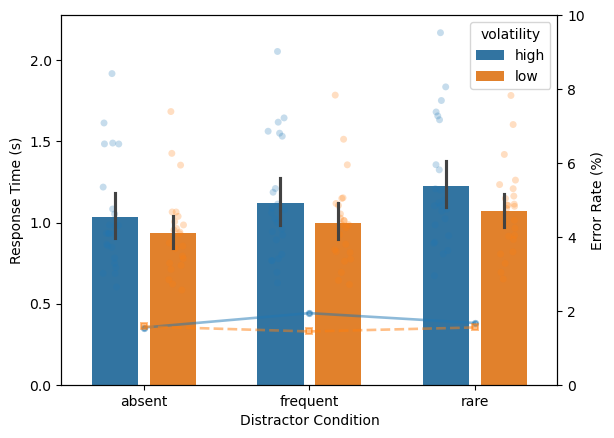

In [18]:
def plot_rt(ax):
    # initialize the plot size
    #ax.figure.set_size_inches(3.5, 3.5)
    # visualize the mean rt and error rate within one graph as scatter plot and bar plot
    sns.barplot(data=grouped_data, x='dist_bias', y='mean_rt', hue='volatility', 
                width=0.7, gap = 0.2, ax = ax)
    # add stripplot on top of the bar plot
    sns.stripplot(data=grouped_data, x='dist_bias', y='mean_rt', hue='volatility', 
                  dodge=True, alpha = .25, zorder =1, legend = False, ax = ax)
    # y-axis label: Response Time (s)
    ax.set_ylabel('Response Time (s)')
    ax.set_xlabel('Distractor Condition')    
    # add right y-axis label: Error Rate (%), without confidence interval
    ax2 = ax.twinx()
    sns.pointplot(data=grouped_data, x='dist_bias', y='error_rate', hue='volatility', markers = ['o', 's'], 
                  linestyles = ['-', '--'],  join = False, scale = 0.7, alpha = 0.5, ci = None, legend = False, ax = ax2)

    ax2.set_ylim(0, 10)
    ax2.set_ylabel('Error Rate (%)')

plot_rt(plt.gca())


In [19]:
##Statistics: global inhibition_rt
pg.rm_anova(dv='error_rate', within=['volatility','dist_bias'], subject='sub', data=grouped_data, detailed=True).round(3)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,volatility,1.382,1,23,1.382,0.301,0.588,0.588,0.003,1.000
1,dist_bias,0.401,2,46,0.201,0.338,0.715,0.705,0.001,0.954
2,volatility * dist_bias,1.747,2,46,0.874,2.447,0.098,0.104,0.004,0.894


In [20]:
pg.rm_anova(dv='mean_rt', within=['volatility','dist_bias'], subject='sub', data=grouped_data, detailed=True, effsize='np2', correction=True).round(3)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,volatility,0.556,1,23,0.556,12.655,0.002,0.002,0.355,1.000
1,dist_bias,0.654,2,46,0.327,92.987,0.000,0.000,0.802,0.856
2,volatility * dist_bias,0.018,2,46,0.009,6.152,0.004,0.010,0.211,0.746


In [21]:
print("Mean RT for high vs. low volatility:")
round(grouped_data.groupby('volatility').mean_rt.mean()*1000)

Mean RT for high vs. low volatility:


volatility
high    1127.0
low     1002.0
Name: mean_rt, dtype: float64

On average, RTs were 125 ms slower when participants performed the task under high- vs. low-volatility trial-sequence conditions (1127 ms vs. 1002 ms).

Note for the statistics: There was no significant differences for the error rates. However, Both volatlity and distractor types and their interaction were significant for the RTs. This is likely due to the different distractor interference (high vs. low) in the high vs. low volatility conditions. 


### Distractor interference and distractor-location (probability-cueing effect)

To better understand the interaction, we use the `distractor absent` condition as the baseline, and compare the distractor interference effect defined by the difference between rare and frequent locations, in the high vs. low volatility conditions.

In [22]:
# now pivot dist_bias to columns, and calculate differences between rare and freq within each volatility and sub
prob_cueing = (grouped_data
        .pivot_table(index=['sub', 'volatility'], columns='dist_bias', values='mean_rt')
        .assign(pcue = lambda df: (df['rare'] - df['frequent'])*1000,
                dis_freq=lambda df: (df['frequent'] - df['absent'])*1000,
                dis_rare = lambda df: (df['rare'] - df['absent'])*1000) # probablistic cueing effect
        .reset_index())
print(prob_cueing.groupby('volatility')[['pcue', 'dis_freq','dis_rare']].mean().round())



dist_bias    pcue  dis_freq  dis_rare
volatility                           
high        106.0      86.0     192.0
low          74.0      64.0     138.0


In the high volatility session, the distractor inference was 86 ms for the distractor at the frequent location and 192 ms for those at at rare locations. In the low volatility session, the interference measured 64 ms for the requent location and 138 ms for rare locations.

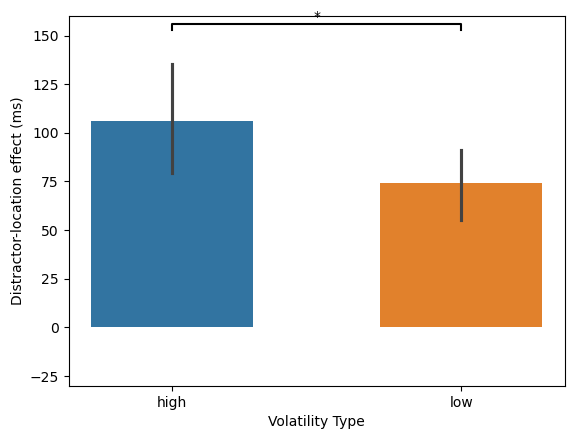

In [23]:
def plot_dcue(ax):
    # initialize the plot size
    #ax.figure.set_size_inches(3.5, 3.5)
    # visualize the mean probability cueing (`pcue`) for each volatility as bar plot
    sns.barplot(data=prob_cueing, x='volatility', y='pcue', hue = 'volatility', width = 0.7, gap = 0.2, ax=ax)
    ax.set_ylabel('Distractor-location effect (ms)')
    ax.set_xlabel('Volatility Type')
    # add significance bar and annotation
    y_max = 150
    y, h, col = y_max + y_max/50, y_max/50, 'k'
    ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((0+1)/2, y+h, "*", ha='center', va='bottom', color=col)
    ax.set_ylim(-30, 160)

plot_dcue(plt.gca())


In [24]:
pg.pairwise_tests(dv ='pcue', within=['volatility'], subject='sub', 
                  data=prob_cueing, padjust='fdr_bh', effsize='cohen').round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,volatility,high,low,True,True,2.35,23.0,two-sided,0.028,2.087,0.525


statistical note: the probability cueing was higher in the high volatility condition than the low volatility condition.



### Target-location effect

Next, we will examine the Target location effect, defined by the target appeared at the frequent vs. rare locations, separately for the high vs. low volatility conditions.

In [25]:
# target location was stored in the column `tar_bias`
target_location = (data.query('tar_bias != "none"') #filter out distractor present trials
                     .groupby(['sub', 'volatility', 'tar_bias'])
                     .agg(mean_rt=('rt', 'mean'))
                     .pivot_table(index=['sub', 'volatility'], columns='tar_bias', values='mean_rt')
                     .assign(ptar=lambda x: (x['frequent'] - x['rare'])*1000,  # target location effect
                             rptar = lambda x: ((x['frequent'] - x['rare'])/(x['frequent'] + x['rare'])*2)) # relative target location effect
                     .reset_index())
print(target_location.groupby('volatility')[['ptar', 'rptar']].mean().round(3))

tar_bias      ptar  rptar
volatility               
high        84.560  0.083
low         14.523  0.019


In [26]:
# statistical test of target location effect `ptar` between volatilities
pg.pairwise_ttests(dv='ptar', within='volatility', subject='sub', data=target_location, padjust='fdr_bh', effsize='cohen').round(4)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,volatility,high,low,True,True,3.5385,23.0,two-sided,0.0018,21.465,0.6146


In [27]:
pg.pairwise_ttests(dv='rptar', within='volatility', subject='sub', data=target_location, padjust='fdr_bh', effsize='cohen').round(4)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,volatility,high,low,True,True,4.1593,23.0,two-sided,0.0004,82.57,0.5816


Both absolute and relative target-location effects differ significantly. 

In [28]:
pg.ttest(target_location.query('volatility=="low"').ptar, 0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.646604,23,two-sided,0.524289,"[-31.94, 60.98]",0.131987,0.26,0.095067


In [29]:
pg.ttest(target_location.query('volatility=="high"').ptar, 0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.518449,23,two-sided,0.001843,"[34.84, 134.28]",0.7182,20.569,0.920459


In [30]:
pg.multicomp([0.524, 0.0018], method='bonf')

(array([False,  True]), array([1.    , 0.0036]))

the target-location effect turned out to be 85 ms for the high-volatility condition, which was significantly higher than the effect in the low-volatility condition (15 ms), t(23) = 3.53, p = 0.002, BF10 = 21.46, d = 0.62. And while the effect was significantly positive in the high-volatility condition, t(23) = 3.52, p = 0.0036, Bonferoni-corrected, BF10 = 20.57, d = 0.72, it did not differ reliably from zero in the low-volatility condition, t(23) = 0.65, p = 0.52, BF10 = 0.25, d = 0.13. 

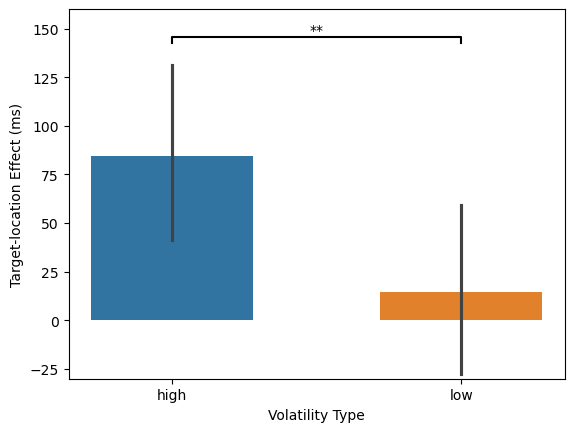

In [31]:
def plot_tloc(ax):
    # initialize the plot size
    #ax.figure.set_size_inches(3.5, 3.5)
    # visualize the `ptar` for each volatility as bar plot
    sns.barplot(data=target_location, x='volatility', y='ptar', hue = 'volatility', width = 0.7, gap = 0.2, ax = ax)
    # add stripplot on top of the bar plot
    #sns.stripplot(data=target_location, x='volatility', y='ptar', hue='volatility',  alpha = .25, zorder =1, legend = False)
    ax.set_ylabel('Target-location Effect (ms)')
    ax.set_xlabel('Volatility Type')
    # add significance bar and annotation
    y_max = 140
    y, h, col = y_max + y_max/50, y_max/50, 'k'
    ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((0+1)/2, y+h, "**", ha='center', va='bottom', color=col)
    ax.set_ylim(-30, 160)
    


plot_tloc(plt.gca())

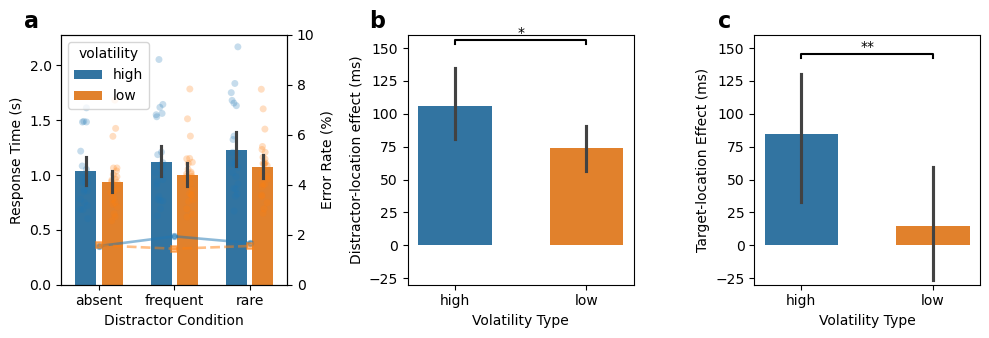

In [32]:
# combine plot_rt, plot_pcue, and plot_tloc into one figure
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
plot_rt(axes[0])
axes[0].text(-0.1, 1.1, 'a', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_dcue(axes[1])
axes[1].text(-0.1, 1.1, 'b', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_tloc(axes[2])
axes[2].text(-0.1, 1.1, 'c', transform=axes[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.show()
# save the figure
fig.savefig('./figs/fig2.png', dpi=300, bbox_inches='tight')
fig.savefig('./figs/fig2.pdf', dpi=300, bbox_inches='tight')

###  Distrator repetition suppression effect

#### Distractor interference and distractor repetition

In [33]:
# average rt for each sub, volatility, and dist_repe from data
# 
dist_rt_sub0 = (data.query("dist_repe < 5")
               .groupby(['sub', 'volatility','dist_repe'])
               .agg({'rt':'mean', 'correct':'count'})
               .rename(columns={'correct':'trial_count'})
               .reset_index())

# select dist_repe ==0 as baseline, and merge back to the original data (exclude dist_repe == 0)
baseline_rt = dist_rt_sub0.query('dist_repe == 0').rename(columns={'rt': 'baseline_rt'}).drop(columns=['dist_repe', 'trial_count'])
dist_rt_sub = (dist_rt_sub0
               .merge(baseline_rt, on=['sub', 'volatility'], how='left')
               .query('dist_repe != 0').
               assign(interference=lambda df: (df['rt'] - df['baseline_rt'])*1000))
dist_rt_sub.head().round(3)

,sub,volatility,dist_repe,rt,trial_count,baseline_rt,interference
1,1,high,1,1.218,510,0.985,233.164
2,1,high,2,1.134,155,0.985,148.383
3,1,high,3,1.097,39,0.985,111.972
4,1,high,4,1.072,9,0.985,87.182
6,1,low,1,1.071,213,0.847,224.123


In [34]:
# check grand mean of interference and the average number of trials
(dist_rt_sub.groupby(['volatility', 'dist_repe']).agg({'interference':'mean', 'trial_count':'mean'}).reset_index()
    .pivot_table(index=['volatility'], columns='dist_repe', values='trial_count').round(3))

dist_repe,1,2,3,4
volatility,,,,
high,508.125,152.667,45.875,11.375
low,218.375,163.208,109.875,73.583


From above we know the number of trials in high volatility with 4 consecutive distractor repetititons is 11.3. Others are more than 45. 

In [35]:
dist_rt_sub0.head()

,sub,volatility,dist_repe,rt,trial_count
0,1,high,0,0.985284,724
1,1,high,1,1.218448,510
2,1,high,2,1.133667,155
3,1,high,3,1.097256,39
4,1,high,4,1.072466,9


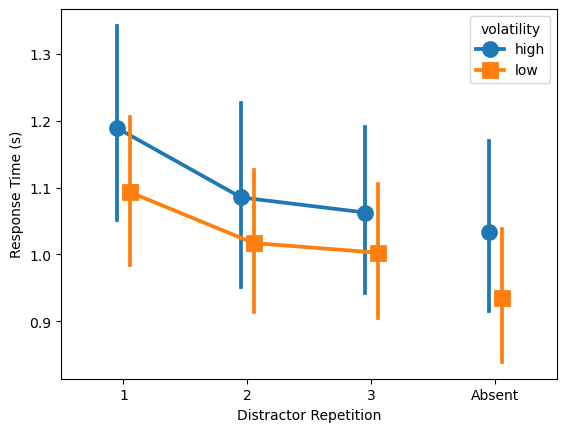

In [36]:
# visualize the rt as a function of dist_repe from dist_rt_sub0
def plot_rt_rep(ax):
	sns.pointplot(data=dist_rt_sub0.query("dist_repe <4 & dist_repe >0"), x='dist_repe', y='rt', 
				markers=['o','s'], markersize=10, dodge = 0.1, hue='volatility', ax=ax, legend=False)
	sns.pointplot(data=dist_rt_sub0.query("dist_repe ==0"), x='dist_repe', y='rt',
				markers=['o','s'], markersize=10, dodge = 0.1,  hue='volatility', ax=ax)
	ax.set_ylabel('Response Time (s)')
	ax.set_xlabel('Distractor Repetition')
	# set x-ticks labels to 1,2,3, Absent
	ax.set_xticklabels(['1', '2', '3', 'Absent'])
	plt.tight_layout
	
plot_rt_rep(plt.gca())

In [37]:
#repeated measures ANOVA for rt with dist_repe < 4
pg.rm_anova(dv='rt', within=['dist_repe', 'volatility'], subject='sub', data=dist_rt_sub0.query('dist_repe < 4'), detailed=True).round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,dist_repe,0.618,3,69,0.206,50.542,0.000,0.000,0.034,0.556
1,volatility,0.313,1,23,0.313,5.397,0.029,0.029,0.017,1.000
2,dist_repe * volatility,0.014,3,69,0.005,1.266,0.293,0.280,0.001,0.411


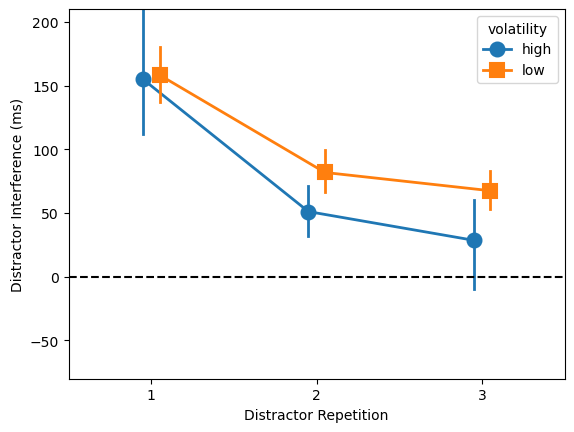

In [38]:
def plot_pcue(ax):
    # visualize the interference effect as a function of dist_repe, separated by volatility, line plot
    sns.pointplot(data=dist_rt_sub.query('dist_repe <4'), x='dist_repe', y='interference', 
                 hue='volatility', markers=['o','s'], markersize=10, dodge = 0.1, 
                 linewidth=2, ax = ax)
    ax.set_xlabel('Distractor Repetition')
    ax.set_ylabel('Distractor Interference (ms)')
    ax.axhline(0, color='k', linestyle='--')
    ax.set_ylim(-80, 210)


plot_pcue(plt.gca())

In [39]:
# repeated measures ANOVA for interference effect
pg.rm_anova(dv='interference', within=['dist_repe', 'volatility'], subject='sub', data=dist_rt_sub, detailed=True, effsize='np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,dist_repe,365121.529,3,69,121707.176,23.599,0.000,0.000,0.506,0.575
1,volatility,10330.942,1,23,10330.942,1.662,0.210,0.210,0.067,1.000
2,dist_repe * volatility,21698.614,3,69,7232.871,1.258,0.295,0.293,0.052,0.641


In [40]:
# repeated measures ANOVA for interference effect
pg.rm_anova(dv='interference', within=['dist_repe', 'volatility'], subject='sub', data=dist_rt_sub.query('dist_repe <4'), detailed=True, effsize='np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,dist_repe,323904.465,2,46,161952.232,33.029,0.000,0.000,0.589,0.607
1,volatility,21284.933,1,23,21284.933,11.194,0.003,0.003,0.327,1.000
2,dist_repe * volatility,8303.018,2,46,4151.509,0.808,0.452,0.392,0.034,0.565


Repetition suppression was significant, but not the volality effect. 

#### Distractor location probability cueing and distractor repetition

In [41]:
dist_loc_rt_l = (data.query("dist_repe > 0 and dist_repe < 5")
               .groupby(['sub', 'volatility','dist_repe','dist_bias'])
               .agg({'rt':'mean', 'correct':'count'}) # calculate mean rt and trial count
                .rename(columns={'correct':'trial_count'})
                .reset_index())
# check average number of trials
dist_loc_rep = (dist_loc_rt_l.groupby(['volatility',  'dist_bias', 'dist_repe'])
 .agg({'trial_count':'mean'}).reset_index()
 .pivot_table(index=['volatility', 'dist_bias'], columns='dist_repe', values='trial_count').round(2)).reset_index()
dist_loc_rep

dist_repe,volatility,dist_bias,1,2,3,4
0,high,frequent,327.62,97.62,29.25,7.04
1,high,rare,180.50,55.04,16.62,4.33
2,low,frequent,139.12,102.33,68.67,45.83
3,low,rare,79.25,60.88,41.21,27.75


In [42]:
dist_loc_rt_l.head()

,sub,volatility,dist_repe,dist_bias,rt,trial_count
0,1,high,1,frequent,1.207529,334
1,1,high,1,rare,1.239445,176
2,1,high,2,frequent,1.149240,96
3,1,high,2,rare,1.110864,59
4,1,high,3,frequent,1.084276,25


note: the average trial number for repetition of 4 were relatively low for the high-volatility session (7.04 and 4.33)

In [43]:

dist_loc_rt = (dist_loc_rt_l
               .drop(columns=['trial_count'])
               .pivot_table(index=['sub', 'volatility','dist_repe'], columns='dist_bias', values='rt')
               .assign(location=lambda df: (df['rare'] - df['frequent'])*1000).reset_index())
dist_loc_rt.head().round(3)

dist_bias,sub,volatility,dist_repe,frequent,rare,location
0,1,high,1,1.208,1.239,31.916
1,1,high,2,1.149,1.111,-38.376
2,1,high,3,1.084,1.120,35.232
3,1,high,4,1.105,1.018,-86.673
4,1,low,1,1.026,1.164,137.867


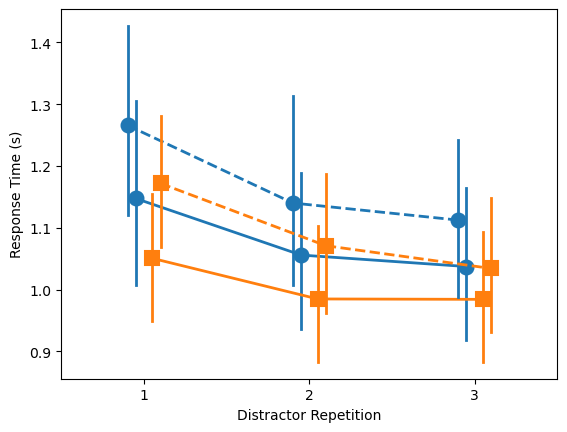

In [44]:
def plot_disrep2(ax):
    sns.pointplot(data=dist_loc_rt.query('dist_repe <4'), x='dist_repe', y='frequent', 
                 hue='volatility',   markers=['o','s'], markersize=10, dodge = 0.1, 
                 linewidth=2, ax = ax, legend=False)
    sns.pointplot(data=dist_loc_rt.query('dist_repe <4'), x='dist_repe', y='rare', 
                 hue='volatility',  markers=['o','s'], markersize=10, dodge = 0.2, linestyles='--',
                 linewidth=2, ax = ax, legend = False)
#    sns.pointplot(data=dist_rt_sub0.query("dist_repe ==0"), x='dist_repe', y='rt',
#				markers=['o','s'], markersize=10, dodge = 0.1,  hue='volatility', ax=ax)
    ax.set_ylabel('Response Time (s)')
    ax.set_xlabel('Distractor Repetition')
	# set x-ticks labels to 1,2,3, Absent
    ax.set_xticklabels(['1', '2', '3', 'Absent'])
    plt.tight_layout
	
    

plot_disrep2(plt.gca())

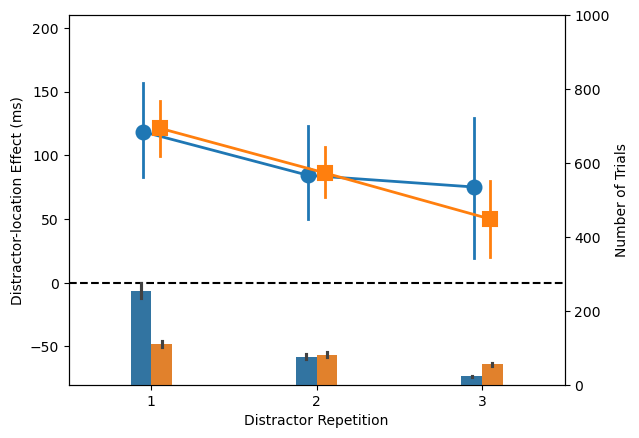

In [45]:
def plot_disrep(ax):
    # visualize the location effect as a function of dist_repe, separated by volatility, line plot
    sns.pointplot(data=dist_loc_rt.query('dist_repe < 4'), x='dist_repe', y='location', 
                  hue='volatility', markers=['o','s'], markersize=10, dodge = 0.1, 
                  linewidth=2, ax = ax, legend = False)
    ax.set_xlabel('Distractor Repetition')
    ax.set_ylabel('Distractor-location Effect (ms)')
    # add dashed line at 0
    ax.axhline(0, color='k', linestyle='--')
    # set y-axis limit to -50 to 200
    ax.set_ylim(-80, 210)
    # add right y-axis label: number of trials
    ax2 = ax.twinx()
    sns.barplot(data=dist_loc_rt_l.query('dist_repe <4'), x='dist_repe', y='trial_count', 
                    hue='volatility',  dodge = 0.1, width=0.25, 
                     ax=ax2, legend=False)
	#sns.lineplot(data=dist_loc_rt_l, x='dist_repe', y='trial_count', hue='dist_bias', style='volatility', ci='sd')
    ax2.set_ylabel('Number of Trials')
    ax2.set_ylim(0, 1000)

plot_disrep(plt.gca())

In [46]:
# repeated measures ANOVA for location effect
pg.rm_anova(dv='location', within=['dist_repe', 'volatility'], subject='sub', data=dist_loc_rt, detailed=True, effsize='np2').round(2)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,dist_repe,184269.79,3,69,61423.26,3.84,0.01,0.04,0.14,0.52
1,volatility,923.11,1,23,923.11,0.04,0.84,0.84,0.00,1.00
2,dist_repe * volatility,24109.12,3,69,8036.37,0.50,0.69,0.58,0.02,0.56


In [47]:
pg.rm_anova(dv='location', within=['dist_repe', 'volatility'], subject='sub', data=dist_loc_rt.query('dist_repe < 4'), 
			detailed=True, effsize='np2').round(2)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,dist_repe,79990.08,2,46,39995.04,5.88,0.01,0.01,0.20,0.81
1,volatility,1667.61,1,23,1667.61,0.26,0.62,0.62,0.01,1.00
2,dist_repe * volatility,6073.35,2,46,3036.68,0.41,0.67,0.59,0.02,0.67


In [48]:
target_loc_rt_l = (data.query("dist_repe_absent > 0 and dist_repe_absent < 5 and dist_bias == 'absent'")
               .groupby(['sub', 'volatility','dist_repe_absent','tar_bias'])
               .agg({'rt':'mean', 'correct':'count'}) # calculate mean rt and trial count
                .rename(columns={'correct':'trial_count'})
                .reset_index())
# check average number of trials
(target_loc_rt_l.groupby(['volatility', 'tar_bias', 'dist_repe_absent'])
 .agg({'trial_count':'mean'}).reset_index()
 .pivot_table(index=['volatility', 'tar_bias'], columns='dist_repe_absent', values='trial_count').round(3))


dist_repe_absent           1        2       3       4
volatility tar_bias                                  
high       frequent   95.458   26.292   7.625   2.571
           rare      412.958  122.667  36.417  10.833
low        frequent   42.083   29.042  18.500  12.750
           rare      176.000  121.625  85.958  60.042

The target repetition of 4 for the high volatlity condition at the frequent distractor location was rare, on average 2.57 trials. 

Given the average number of trials for the target location at high vol/ dist frequent locaiton is rare, we only use the repetition from 1 to 3. 

In [49]:

target_loc_rt = (target_loc_rt_l
                 .query('dist_repe_absent < 4')
                .drop(columns=['trial_count'])
               .pivot_table(index=['sub', 'volatility','dist_repe_absent'], columns='tar_bias', values='rt')
               .assign(location=lambda df: (df['frequent'] - df['rare'])*1000).reset_index())
target_loc_rt.head()

tar_bias,sub,volatility,dist_repe_absent,frequent,rare,location
0,1,high,1,0.968713,1.006274,-37.560823
1,1,high,2,0.851368,0.983339,-131.971397
2,1,high,3,0.994422,0.961247,33.174801
3,1,low,1,0.984914,0.849897,135.017022
4,1,low,2,0.813077,0.852792,-39.714991


In [51]:
# repeated measures ANOVA for target location effect
pg.rm_anova(dv='location', within=['dist_repe_absent', 'volatility'], subject='sub', data=target_loc_rt, detailed=True, effsize='np2').round(2)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,dist_repe_absent,128476.61,2,46,64238.31,13.99,0.00,0.00,0.38,0.94
1,volatility,109252.97,1,23,109252.97,6.56,0.02,0.02,0.22,1.00
2,dist_repe_absent * volatility,2729.36,2,46,1364.68,0.16,0.85,0.81,0.01,0.84


In [52]:
# repeated measures ANOVA for target location effect only for repetition of 1
pg.rm_anova(dv='location', within=['volatility'], subject='sub', data=target_loc_rt.query('dist_repe_absent == 1'), detailed=True, effsize='np2').round(2)


,Source,SS,DF,MS,F,p-unc,np2,eps
0,volatility,21996.16,1,21996.16,1.47,0.24,0.06,1.0
1,Error,344108.23,23,14961.23,NaN,NaN,NaN,NaN


In [53]:
pg.pairwise_tests(dv ='location', within=['dist_repe_absent'], subject='sub', interaction=False,
				  data=target_loc_rt, padjust='bonf', effsize='cohen').round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,dist_repe_absent,1,2,True,True,5.085,23.0,two-sided,0.000,0.000,bonf,649.443,0.637
1,dist_repe_absent,1,3,True,True,3.235,23.0,two-sided,0.004,0.011,bonf,11.37,0.335
2,dist_repe_absent,2,3,True,True,-2.297,23.0,two-sided,0.031,0.093,bonf,1.903,-0.308


In [54]:
pg.ttest(target_loc_rt.query('volatility=="low"').location, 0).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.81,71,two-sided,0.42,"[-20.22, 47.85]",0.1,0.177,0.13


In [55]:
# test the target location effect for the low volatility sesstion, repetition of 1
pg.ttest(target_loc_rt.query('volatility=="low" and dist_repe_absent == 1').location, 0).round(2)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.66,23,two-sided,0.11,"[-13.92, 128.41]",0.34,0.712,0.36


In [56]:
print(pg.ttest(target_loc_rt.query('volatility=="high" and dist_repe_absent == 1').location, 0).round(3))
print(pg.ttest(target_loc_rt.query('volatility=="high" ').location, 0).round(3))


            T  dof alternative  p-val           CI95%  cohen-d    BF10  power
T-test  4.038   23   two-sided  0.001  [48.8, 151.32]    0.824  63.219  0.972
            T  dof alternative  p-val           CI95%  cohen-d   BF10  power
T-test  4.494   71   two-sided    0.0  [38.33, 99.48]     0.53  702.0  0.993


In [57]:
pg.multicomp([0.001, 0.0], method='bonf')

(array([ True,  True]), array([0.002, 0.   ]))

Given that the repetition effect was mainly contributed by the first 'distractor-absent' trials in the high-volatility condition, we wanted to look at if this was contributed by the fact that the target likely at the distractor location in the previous trials (i.e., coincidence trials) is unbalanced. 


In [63]:
target_loc_rt2 = (data.query("dist_repe_absent > 0 and dist_repe_absent < 4 and dist_bias == 'absent' and coincident != 'coincident'")
               .groupby(['sub', 'volatility','dist_repe_absent','tar_bias'])
               .agg({'rt':'mean', 'correct':'count'}) # calculate mean rt and trial count
                .rename(columns={'correct':'trial_count'})
                .reset_index()
               .pivot_table(index=['sub', 'volatility','dist_repe_absent'], columns='tar_bias', values='rt')
               .assign(location=lambda df: (df['frequent'] - df['rare'])*1000).reset_index())
target_loc_rt2.head(10)

tar_bias,sub,volatility,dist_repe_absent,frequent,rare,location
0,1,high,1,0.955638,1.001780,-46.142558
1,1,high,2,0.851368,0.983339,-131.971397
2,1,high,3,0.994422,0.961247,33.174801
3,1,low,1,0.877656,0.845485,32.171581
4,1,low,2,0.813077,0.852792,-39.714991
5,1,low,3,0.701343,0.831544,-130.200480
6,2,high,1,0.608394,0.601157,7.237726
7,2,high,2,0.617895,0.595817,22.077406
8,2,high,3,0.664244,0.603683,60.561343
9,2,low,1,0.656780,0.638931,17.849330


AttributeError: Line2D.set() got an unexpected keyword argument 'facecolors'

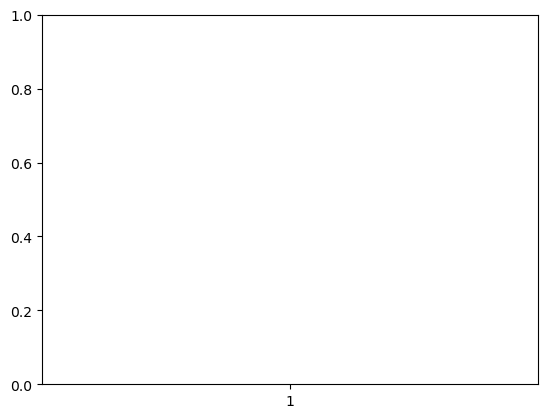

In [73]:
def plot_tarrep(ax):
    # visualize the location effect as a function of dist_repe, separated by volatility, line plot
    # without coincidence
    sns.pointplot(data=target_loc_rt2, x='dist_repe_absent', y='location',
                   hue='volatility',markers=['o','s'], markersize=10, dodge = 0.1, linestyle='--',facecolors='none', 
                    linewidth=2, ax = ax, legend=False,  ci = None)

    sns.pointplot(data=target_loc_rt, x='dist_repe_absent', y='location',
                   hue='volatility',markers=['o','s'], markersize=10, dodge = 0.1, 
                    linewidth=2, ax = ax, legend=False)
    ax.set_xlabel('Distractor-absent Repetition')
    ax.set_ylabel('Target-location effect (ms)')
    # add dashed line at 0
    ax.axhline(0, color='k', linestyle='--')
    # set y-axis limit to -80 to 210
    ax.set_ylim(-80, 210)
    # add right y-axis label: number of trials
    ax2 = ax.twinx()
    sns.barplot(data=target_loc_rt_l.query('dist_repe_absent <4'), x='dist_repe_absent', y='trial_count', 
                    hue='volatility',  dodge = 0.1, width=0.25, 
                     ax=ax2, legend=False)
	#sns.lineplot(data=dist_loc_rt_l, x='dist_repe', y='trial_count', hue='dist_bias', style='volatility', ci='sd')
    ax2.set_ylabel('Number of Trials')
    ax2.set_ylim(0, 1000)

plot_tarrep(plt.gca())

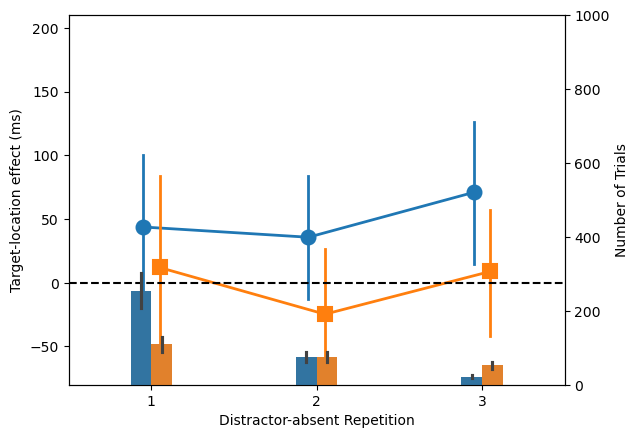

In [67]:
plot_tarrep(plt.gca(), target_loc_rt2)

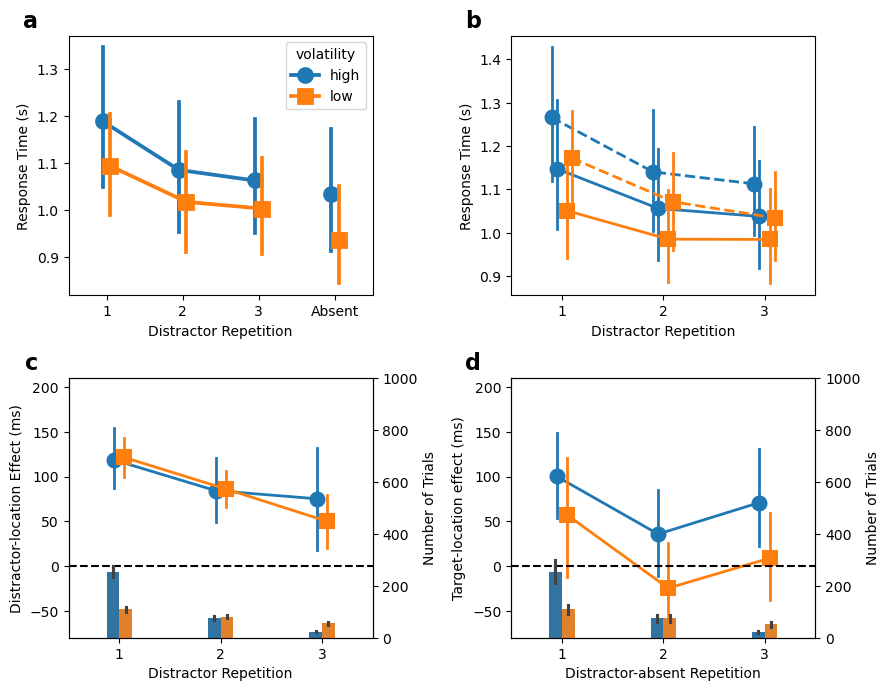

In [49]:
# combine plot_nrep, plot_pcue, plot_disrep, and plot_tarrep into one figure, adding a, b, c, d to each plot
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
plot_rt_rep(axes[0,0])
axes[0,0].text(-0.1, 1.1, 'a', transform=axes[0,0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_disrep2(axes[0,1])
axes[0,1].text(-0.1, 1.1, 'b', transform=axes[0,1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_disrep(axes[1,0])
axes[1,0].text(-0.1, 1.1, 'c', transform=axes[1,0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_tarrep(axes[1,1])
axes[1,1].text(-0.1, 1.1, 'd', transform=axes[1,1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.show()
# save the figure
fig.savefig('./figs/fig3.png', dpi=300, bbox_inches='tight')
fig.savefig('./figs/fig3.pdf', dpi=300, bbox_inches='tight')


### Change from the distractor-absent to distractor-present trials

As shown in the above figure, the distractor interference was comparable in the first encounter of the distractor-present trials, regardless of the distractor volatility. We want to examine further impact of the number of repetition of distractor-absent trials prior to the first encounter of the distractor-present trials.


In [38]:
# shift the column dist_repe_absent one row down, and merge back to the original data as new column `pre_repe`
data['pre_repe'] = data.groupby(['sub', 'volatility'])['dist_repe_absent'].shift(1)
# replace the value with NA for every 160 trials (0, 160, ...) based on index as this was the start of a new block
data.loc[data.index % 160 == 0, 'pre_repe'] = np.nan

# select only those trials with dist_rept == 1 
data1 = data.query('dist_repe == 1 and pre_repe > 0 and pre_repe < 5')
# calculate the mean rt for each subject, volatility, dist_repe, and pre_repe
pre_repe_rt = (data1.groupby(['sub', 'volatility', 'dist_repe', 'pre_repe', 'dist_bias'])
			   .agg(mean_rt=('rt', 'mean'))
			   .reset_index())
# spread the 'dist_bias' to columns, and calculate the difference between mean_rt of rare and frequent
pre_repe_rt = (pre_repe_rt.pivot_table(index=['sub', 'volatility', 'dist_repe', 'pre_repe'], columns='dist_bias', values='mean_rt')
			   .assign(location=lambda df: (df['rare'] - df['frequent'])*1000)
			   .reset_index())
pre_repe_rt.head()


dist_bias,sub,volatility,dist_repe,pre_repe,frequent,rare,location
0,1,high,1,1.0,1.199625,1.256382,56.757176
1,1,high,1,2.0,1.233749,1.173035,-60.713898
2,1,high,1,3.0,1.156992,1.304572,147.580596
3,1,high,1,4.0,1.239835,1.168321,-71.513887
4,1,low,1,1.0,1.024429,1.272892,248.462879


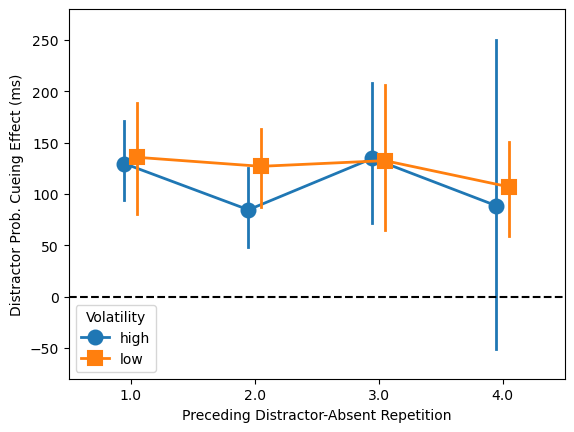

In [45]:
# visualize the pre_reptition location effect
def plot_prerep(ax):
	# visualize the location effect as a function of pre_repe, separated by volatility, line plot
	sns.pointplot(data=pre_repe_rt, x='pre_repe', y='location', hue='volatility', 
			   markers=['o','s'], markersize=10, dodge = 0.1, linewidth=2, ax = ax)
	ax.set_xlabel('Preceding Distractor-Absent Repetition')
	ax.set_ylabel('Distractor Prob. Cueing Effect (ms)')
	# add dashed line at 0
	ax.axhline(0, color='k', linestyle='--')
	# set y-axis limit to -50 to 200
	ax.set_ylim(-80, 280)
	# set legend
	ax.legend(title='Volatility', loc='lower left')
	

plot_prerep(plt.gca())

	

### Inter-trial analysis


For inter-trial analysis, we need to exclude the first trial of each block. The inter-trial condition is stored in `dist_attendance` (AP, PA, PP, AA). 

In [81]:
# exclude dist_attendance is NaN as True for exclude column without affecting those have already been excluded
data['exclude'] = data['exclude'] | data['dist_attendance'].isna()
print(f"(the percentage of exclude trials is: {data.exclude.mean()*100:.2f}%)")

(the percentage of exclude trials is: 4.19%)


In [104]:
# average rt for each sub, volatility, and dist_attendance (switch types) from data
dist_att_rt = (data.query("exclude == False").
               groupby(['sub', 'volatility','dist_attendance'])
               .agg({'rt':'mean', 'correct':'count'})
               .rename(columns={'correct':'trial_count'})
               .reset_index())

(dist_att_rt.groupby(['volatility', 'dist_attendance']).rt.mean().
    reset_index().pivot_table(index=['volatility'], 
                              columns='dist_attendance', values='rt').round(2))

dist_attendance,AA,AP,PA,PP
volatility,,,,
high,1.02,1.19,1.04,1.08
low,0.92,1.09,0.96,1.00


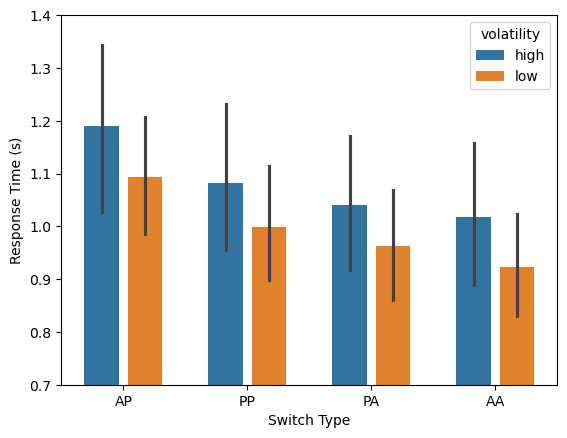

In [121]:
def plot_switch(ax):
    sns.barplot(data=dist_att_rt, x='dist_attendance', y='rt', hue='volatility', 
                width=0.7, gap = 0.2, ax = ax, order = ['AP', 'PP', 'PA', 'AA'])
    # set y-axis range to 0.7 to 1.2
    ax.set_ylim(0.7, 1.4)
    ax.set_ylabel('Response Time (s)')
    ax.set_xlabel('Switch Type')

plot_switch(plt.gca())

In [106]:
# repeated measures ANOVA for switch type effect and volatility
pg.rm_anova(dv='rt', within=['dist_attendance', 'volatility'], subject='sub', data=dist_att_rt, detailed=True, effsize='np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,dist_attendance,0.791,3,69,0.264,70.958,0.000,0.000,0.755,0.515
1,volatility,0.374,1,23,0.374,5.934,0.023,0.023,0.205,1.000
2,dist_attendance * volatility,0.003,3,69,0.001,0.405,0.750,0.577,0.017,0.421


In [107]:
# pivot the data to wide from dist_attendance to columns, and calculat the differences DP = AP - PP, DA = PA - AA
dist_att_rt_wide = (dist_att_rt
                    .pivot_table(index=['sub', 'volatility'], columns='dist_attendance', values='rt')
                    .assign(DP=lambda df: (df['AP'] - df['PP'])*1000,
                            DA=lambda df: (df['PA'] - df['AA'])*1000)
                    .reset_index())
# select the difference columns DP and DA and pivot the data to long format
dist_att_rt_long = (dist_att_rt_wide
                    .melt(id_vars=['sub', 'volatility'], value_vars=['DP', 'DA'],
                          var_name='switch_type', value_name='switch_effect'))
dist_att_rt_long.head()

,sub,volatility,switch_type,switch_effect
0,1,high,DP,92.725549
1,1,low,DP,120.774364
2,2,high,DP,14.115938
3,2,low,DP,33.927747
4,3,high,DP,50.856706


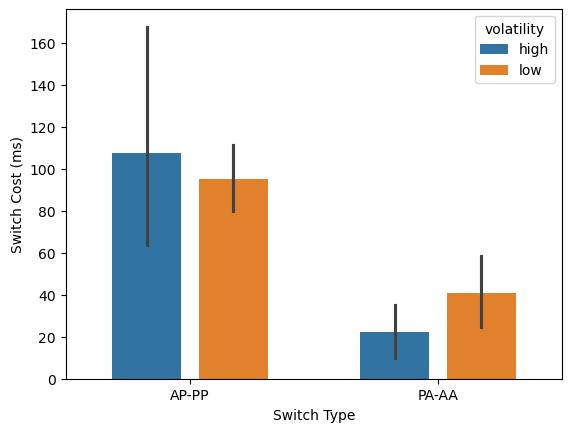

In [122]:
# visualize the switch effect for each volatility as bar plot
def plot_switch_cost(ax):
    sns.barplot(data=dist_att_rt_long, x='switch_type', y='switch_effect', hue='volatility', 
                width=0.7, gap = 0.2, order = ['DP', 'DA'], ax = ax)
    # change x-axis tick labels to 'Current Present' and 'Current Absent'
    ax.set_xticklabels(['AP-PP', 'PA-AA'])
    ax.set_ylabel('Switch Cost (ms)')
    ax.set_xlabel('Switch Type')

plot_switch_cost(plt.gca())


In [123]:
# repeated measures ANOVA for switch effect
pg.rm_anova(dv='switch_effect', within=['switch_type', 'volatility'], subject='sub', data=dist_att_rt_long, detailed=True, effsize='np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,switch_type,116079.739,1,23,116079.739,43.778,0.000,0.000,0.656,1.0
1,volatility,204.865,1,23,204.865,0.041,0.841,0.841,0.002,1.0
2,switch_type * volatility,5792.480,1,23,5792.480,0.745,0.397,0.397,0.031,1.0


The main effect of switch type is significant, but not others. 

In [117]:
#show the average switch effect for switch type
dist_att_rt_long.groupby([ 'switch_type']).switch_effect.mean().reset_index().round()

,switch_type,switch_effect
0,DA,32.0
1,DP,101.0


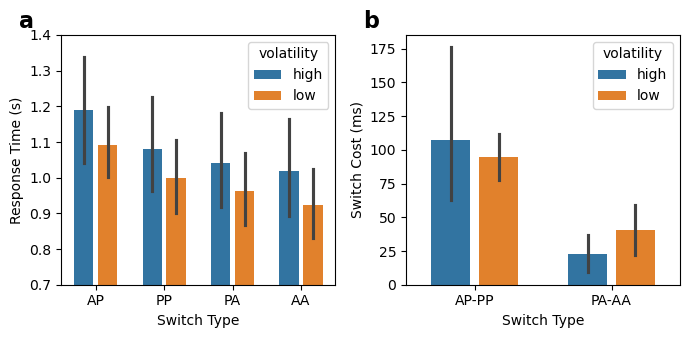

In [124]:
# combine plot_switch and plot_switch_cost into one figure
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
plot_switch(axes[0])
axes[0].text(-0.1, 1.1, 'a', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plot_switch_cost(axes[1])
axes[1].text(-0.1, 1.1, 'b', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.show()
# save the figure
fig.savefig('./figs/fig_s.png', dpi=300, bbox_inches='tight')
fig.savefig('./figs/fig_s.pdf', dpi=300, bbox_inches='tight')


The short-term switch cost was not affected by the volatility of the trial sequence, which is consistent with previous findings (Goschy et al., 2014).